소프트웨어융합최신기술 프로젝트
===

모기 데이터 분석 과제
---

In [1]:
"""
기상청 기후 데이터 파싱 함수
"""

import requests
from bs4 import BeautifulSoup
from calendar import monthrange


def get_days_of_month(year :int, month: int):
    """요청한 년월의 일수를 구하는 함수
    
    Args:
        year (int): 년도
        month (int): 월
    
    Return:
        int
    """
    
    return monthrange(year, month)[1]


def parse_kma_yearly(stn :int, yy :int, obs_key :str):
    """기상청 데이터 1년분량을 요소별로 파싱하는 함수
    
    Args:
        stn (int): 지점코드. 서울(유) 지점은 108
        yy (int): 요청년도
        obs_key (str): 요소코드의 사전 정의한 키 이름
        
    Return:
        list
    """
    
    OBS_DICT = {
        'average_temp': "07", # 평균기온
        'min_temp': "10", # 최저기온
        'max_temp': "08", # 최고기온
        'rainfall': "21", # 강수량
        'average_windspeed': "06", # 평균풍속
        'rel_humadity': "12", # 상대습도
        'sunshine': "35", # 일조량
        'clouds': "59", # 운량
    }
    
    kma_soup = BeautifulSoup(
        requests.get("http://www.kma.go.kr/weather/climate/past_table.jsp", 
                     params={'stn': str(stn), 'yy': str(yy), 'obs': OBS_DICT[obs_key]}).text, 
        'html.parser')

    kma_soup_datatable = kma_soup.find_all("table")[1].tbody.find_all("td")

    kma_data = []
    for month in range(12):
        kma_data.append([]);

    month_count = 0    
    for data in kma_soup_datatable:
        if data.get('scope') == "row":
            if data.string.strip() in ["평균", "합계"]:
                break
            else:
                month_count = 0;
        else:
            try:
                kma_data[month_count].append(float(data.string.strip()))
                month_count += 1;
            except:
                # No valid data
                if(len(kma_data[month_count]) < get_days_of_month(yy, month_count + 1)):
                    kma_data[month_count].append(None)
                month_count += 1;
    
    return kma_data


In [10]:
"""
기후데이터 시각화
"""

from datetime import date, timedelta
import pandas as pd
import time
import math


SEOUL_STN = 108


def get_date_keys(year: int):
    """Getting Date Keys for Pandas Label
    
    Args:
        year (int): year
    Return:
        list - date keys list
    """
    
    date_keys = []
    
    count_date = date(year, 1, 1)
    end_date = date(year, 12, 31)
    
    while count_date <= end_date:
        date_keys.append(count_date.strftime("%Y-%m-%d"))
        count_date += timedelta(days=1)
    
    return date_keys


def merge_lists(nested_list):
    """Convert nested list to one merged list
    
    Args:
        nested_list (list)
    Return:
        list - merged list
    """
    
    merged_list = []
    for nest_list in nested_list:
        merged_list.extend(nest_list)
    return merged_list



def build_kma_dataset():
    kma_dataset = None
    global nan_count
    
    CRAWL_OBS = ['average_temp', 'min_temp', 'max_temp', 'rel_humadity', 'rainfall']
    
    # Retreive kma dataset for 2010 ~ 2016 and merge dataframe
    for year in range(2010, 2016):
        print("Crawling KMA (yy: %d, stn: %d)..." % (year, SEOUL_STN), end='\t')
        start_time = time.time()
        year_origin_data = {"date": get_date_keys(year)}
        for obs in CRAWL_OBS:
            year_origin_data[obs] = merge_lists(parse_kma_yearly(SEOUL_STN, year, obs))
        year_data = pd.DataFrame(year_origin_data)
        kma_dataset = pd.concat([kma_dataset, year_data]) if kma_dataset is not None else year_data
        print("OK (%.2f sec)" % (time.time() - start_time))
        
    # Filling NaN Data
    kma_dataset.rainfall = kma_dataset.rainfall.apply(lambda x: 0.0 if math.isnan(x) else x)
    
    # Reorder columns
    columns_order = CRAWL_OBS[:]
    columns_order.insert(0, 'date')
    kma_dataset = kma_dataset[columns_order]
    
    # Reassign index number
    kma_dataset.index = range(len(kma_dataset))
    
    # Save to csv (cache)
    kma_dataset.to_csv("kma_dataset.csv")

    return kma_dataset


display(build_kma_dataset().tail())

Crawling KMA (yy: 2010, stn: 108)...	OK (1.92 sec)
Crawling KMA (yy: 2011, stn: 108)...	OK (1.72 sec)
Crawling KMA (yy: 2012, stn: 108)...	OK (1.51 sec)
Crawling KMA (yy: 2013, stn: 108)...	OK (1.66 sec)
Crawling KMA (yy: 2014, stn: 108)...	OK (1.80 sec)
Crawling KMA (yy: 2015, stn: 108)...	OK (1.58 sec)


,date,average_temp,min_temp,max_temp,rel_humadity,rainfall
2186,2015-12-27,-5.7,-8.9,-1.0,39.0,0.0
2187,2015-12-28,-5.7,-9.5,-1.0,38.4,0.0
2188,2015-12-29,-3.2,-8.7,2.9,47.6,0.0
2189,2015-12-30,0.3,-3.5,4.3,67.6,2.5
2190,2015-12-31,0.7,-1.9,2.8,81.3,0.0


In [11]:
"""
모기 데이터 가공 및 시각화
"""

import json
import glob
import math

DATASET_PATH = "./mosquito_data/"
ERROR_LIMIT = 2560
STABLE_LIMIT = 1200


def load_observatory_info(observatory_name :str):
    """Load observatory information
    
    Args:
        observatory_name (str): Observatory Name
    Return:
        dict - Observatory Information dictionary
    """
    
    with open(DATASET_PATH + "observatory.json", "r") as obs_list_file:
        obs_list = json.load(obs_list_file)
        return obs_list[observatory_name]


def build_mosquito_dataset():
    # Get all csv file in dataset directory
    mosquito_data = None
    
    for file_name in glob.glob(DATASET_PATH + '*.csv'):
        start_time = time.time()
        
        observatory_name, year = file_name.replace(DATASET_PATH, "").replace(".csv", "").split("_")
        print("Building %s%s..." % (observatory_name, year), end='\t')
        file_data = pd.read_csv(file_name, header=None)
        file_data.columns = ["date", "mosquito_count"]
        
        # Remove Error Data
        start_time = time.time()
        
        file_data = file_data[file_data["mosquito_count"] < ERROR_LIMIT]
        file_data.mosquito_count = file_data.mosquito_count.apply(lambda x: x if x<STABLE_LIMIT else float(STABLE_LIMIT))
        file_data["level"] = file_data.mosquito_count.apply(lambda x: math.ceil(math.log(x/10, 2)) + 1 if x > 10 else 1)
        
        # Add Observatory Information
        start_time = time.time()
        
        observatory_info = load_observatory_info(observatory_name)
        file_data['obs_label'] = observatory_name
        file_data['obs_type'] = observatory_info["type"]
        file_data['latitude'] = observatory_info["lat"]
        file_data['longitude'] = observatory_info["lng"]
        
        print("OK (%.2f sec)" % (time.time() - start_time))
        
        # Merge Datatable
        mosquito_data = pd.concat([mosquito_data, file_data]) if mosquito_data is not None else file_data
    
    # Reformat date column
    mosquito_data.date = mosquito_data.date.apply(lambda x: str(x)[:10])
    
    # Reassign index number
    mosquito_data.index = range(len(mosquito_data))
    
    # Save to csv (cache)
    mosquito_data.to_csv("mosquito_dataset.csv")
        
    return mosquito_data


display(build_mosquito_dataset().tail())

Building A2012...	OK (0.00 sec)
Building A2013...	OK (0.00 sec)
Building A2014...	OK (0.00 sec)
Building B2013...	OK (0.00 sec)
Building B2014...	OK (0.00 sec)
Building C2013...	OK (0.00 sec)
Building C2014...	OK (0.00 sec)
Building D2013...	OK (0.01 sec)
Building D2014...	OK (0.00 sec)
Building E2011...	OK (0.00 sec)
Building E2012...	OK (0.00 sec)
Building E2013...	OK (0.00 sec)
Building E2014...	OK (0.00 sec)
Building F2013...	OK (0.00 sec)
Building F2014...	OK (0.00 sec)
Building G2013...	OK (0.00 sec)
Building G2014...	OK (0.00 sec)
Building H2014...	OK (0.00 sec)
Building H2015...	OK (0.00 sec)
Building I2011...	OK (0.00 sec)
Building I2012...	OK (0.00 sec)
Building I2013...	OK (0.00 sec)
Building I2014...	OK (0.00 sec)
Building J2013...	OK (0.00 sec)
Building J2014...	OK (0.00 sec)
Building J2015...	OK (0.00 sec)
Building K2011...	OK (0.00 sec)
Building K2012...	OK (0.00 sec)
Building K2013...	OK (0.00 sec)
Building K2014...	OK (0.00 sec)
Building L2012...	OK (0.00 sec)
Building

,date,mosquito_count,level,obs_label,obs_type,latitude,longitude
10920,2014-10-31,6.0,1,U,2,37.5236,126.916
10921,2014-11-01,14.0,2,U,2,37.5236,126.916
10922,2014-11-02,13.0,2,U,2,37.5236,126.916
10923,2014-11-03,1.0,1,U,2,37.5236,126.916
10924,2014-11-04,2.0,1,U,2,37.5236,126.916


In [28]:
"""
실제 데이터셋 구성 (데이터셋 합치기)
"""

from datetime import datetime, timedelta

DATE_FORMAT = "%Y-%m-%d"


def get_data_from_dataset_by_date(dataset, date, column_name, dayback=0):
    date = datetime.strptime(date, DATE_FORMAT).date() - timedelta(days=dayback)
    return dataset.loc[dataset.date == date.strftime(DATE_FORMAT)].iloc[0][column_name]


def build_dataset(full=False):
    # Read cached kma dataset and get obs list
    print("Reading cached dataset...", end='\t')
    start_time = time.time()
    
    kma_dataset = pd.read_csv("kma_dataset.csv", index_col=0)
    kma_obs_list = list(kma_dataset.columns)
    kma_obs_list.remove('date')
    
    # Read cached mosquito dataset and merge kma data
    mosquito_dataset = pd.read_csv("mosquito_dataset.csv", index_col=0)
    print("OK (%.2f sec)" % (time.time() - start_time))
    
    for kma_obs in kma_obs_list:
        print("Adding KMA[%s]..." % kma_obs, end='\t')
        start_time = time.time()
        
        mosquito_dataset[kma_obs] = mosquito_dataset.date.apply(
            lambda x: get_data_from_dataset_by_date(kma_dataset, x, kma_obs))
        mosquito_dataset[kma_obs + "_past"] = mosquito_dataset.date.apply(
            lambda x: get_data_from_dataset_by_date(kma_dataset, x, kma_obs, 1))
        
        print("OK (%.2f sec)" % (time.time() - start_time))
    
    # Reorder columns
    mosquito_dataset = mosquito_dataset[
        ['obs_label', 'date', 'mosquito_count', # Columns Unnecessary
         'obs_type', 'latitude', 'longitude', 
         'average_temp', 'average_temp_past', 
         'min_temp', 'min_temp_past',
         'max_temp', 'max_temp_past',
         'rel_humadity', 'rel_humadity_past', 
         'rainfall', 'rainfall_past', # Features
         'level'] # Target Value 
    ] 
    
    if full:
        mosquito_dataset.to_csv("full_dataset.csv")
    else:
        mosquito_dataset = mosquito_dataset[
            ['obs_type', 'latitude', 'longitude',
             'min_temp', 'min_temp_past',
             'max_temp', 'max_temp_past',
             'rel_humadity', 'rel_humadity_past',
             'average_temp', 'average_temp_past',
             'rainfall', 'rainfall_past',
             'level']
        ]
        mosquito_dataset.to_csv("dataset.csv")
    
    return mosquito_dataset


display(build_dataset().tail())
    

Reading cached dataset...	OK (0.02 sec)
Adding KMA[average_temp]...	OK (26.48 sec)
Adding KMA[min_temp]...	OK (19.75 sec)
Adding KMA[max_temp]...	OK (19.66 sec)
Adding KMA[rel_humadity]...	OK (19.70 sec)
Adding KMA[rainfall]...	OK (19.53 sec)


,obs_type,latitude,longitude,min_temp,min_temp_past,max_temp,max_temp_past,rel_humadity,rel_humadity_past,average_temp,average_temp_past,rainfall,rainfall_past,level
10920,2,37.5236,126.916,12.8,7.7,18.2,20.8,62.1,45.8,15.0,14.2,0.2,0.0,1
10921,2,37.5236,126.916,15.1,12.8,22.9,18.2,63.4,62.1,17.3,15.0,0.0,0.2,2
10922,2,37.5236,126.916,7.1,15.1,15.4,22.9,50.5,63.4,12.0,17.3,2.5,0.0,2
10923,2,37.5236,126.916,3.8,7.1,14.8,15.4,40.9,50.5,9.3,12.0,0.0,2.5,1
10924,2,37.5236,126.916,5.4,3.8,18.5,14.8,60.5,40.9,11.3,9.3,0.0,0.0,1


,latitude,longitude,min_temp,min_temp_past,max_temp,max_temp_past,rel_humadity,rel_humadity_past,average_temp,average_temp_past,rainfall,rainfall_past,obs_type,level
10920,37.5236,126.916,12.8,7.7,18.2,20.8,62.1,45.8,15.0,14.2,0.2,0.0,2,1
10921,37.5236,126.916,15.1,12.8,22.9,18.2,63.4,62.1,17.3,15.0,0.0,0.2,2,2
10922,37.5236,126.916,7.1,15.1,15.4,22.9,50.5,63.4,12.0,17.3,2.5,0.0,2,2
10923,37.5236,126.916,3.8,7.1,14.8,15.4,40.9,50.5,9.3,12.0,0.0,2.5,2,1
10924,37.5236,126.916,5.4,3.8,18.5,14.8,60.5,40.9,11.3,9.3,0.0,0.0,2,1


           latitude    longitude      min_temp  min_temp_past      max_temp  \
count  10925.000000  10925.00000  10925.000000   10925.000000  10925.000000   
mean      37.518131    126.90328     16.807799      16.874517     25.199817   
std        0.011712      0.01372      7.186669       7.104141      6.807249   
min       37.494000    126.88100     -9.500000      -9.500000     -4.300000   
25%       37.511400    126.89400     12.800000      12.900000     22.400000   
50%       37.519700    126.90200     18.700000      18.700000     27.000000   
75%       37.526300    126.91300     22.000000      22.000000     29.700000   
max       37.539500    126.93300     28.700000      28.700000     36.700000   

       max_temp_past  rel_humadity  rel_humadity_past  average_temp  \
count   10925.000000  10925.000000       10925.000000  10925.000000   
mean       25.261419     65.698426          65.742755     20.589977   
std         6.721291     13.622385          13.636995      6.774524   
min 

/Users/kde713/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277
actual,1,1,5,4,6,5,3,6,1,1,...,3,4,3,2,1,3,5,1,1,2
predict,1,1,6,4,8,6,1,7,1,1,...,3,4,4,2,1,1,3,1,1,1


Train Accuracy ::  1.0
Test Accuracy ::  0.512202562538
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)


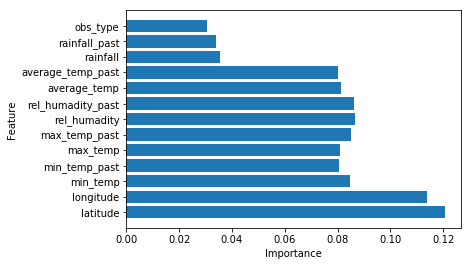

In [33]:
"""
Classification by Random Forest Algorithm
"""

%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """Split the dataset with train_percentage
    
    Args:
        dataset
        train_percentage (float)
        feature_headers (list)
        target_header (str)
    Return:
        train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage, random_state=3)
    return train_x, test_x, train_y, test_y


def random_forest_classifier(features, target):
    clf = RandomForestClassifier(n_jobs=-1, random_state=9, criterion='gini',
                                 n_estimators=500, max_features="auto",
                                 max_depth=26, max_leaf_nodes=None)
    clf.fit(features,target)
    return clf


def plot_feature_importances(features, model):
    n_features = len(features)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

    
def train():
    dataset = pd.read_csv('dataset.csv', index_col=0)
    features = [ 
             'latitude', 'longitude', 
             'min_temp', 'min_temp_past',
             'max_temp', 'max_temp_past',
             'rel_humadity', 'rel_humadity_past',
             'average_temp', 'average_temp_past',
             'rainfall', 'rainfall_past',
             'obs_type',
    ]
    columns = features[:]
    columns.append('level')
    dataset = dataset[columns]
    display(dataset.tail())
    print(dataset.describe())
    train_x,test_x,train_y,test_y = split_dataset(dataset,0.7,features,"level")

    trained_model = random_forest_classifier(train_x,train_y)
    prediction = trained_model.predict(test_x)

    display(pd.DataFrame({"actual": list(test_y), "predict": prediction}).T)

    print ("Train Accuracy :: ",accuracy_score(train_y,trained_model.predict(train_x)))
    print ("Test Accuracy :: ", accuracy_score(test_y,prediction))
    
    plot_feature_importances(features, trained_model)
    
    print(trained_model)
    
    with open("trained_model", "wb") as dumpfile:
        pickle.dump(trained_model, dumpfile)
    
    
train()


,latitude,longitude,min_temp,max_temp,rel_humadity,average_temp,rainfall,rainfall_past,obs_type,level
10920,37.5236,126.916,12.8,18.2,62.1,15.0,0.2,0.0,2,1
10921,37.5236,126.916,15.1,22.9,63.4,17.3,0.0,0.2,2,2
10922,37.5236,126.916,7.1,15.4,50.5,12.0,2.5,0.0,2,2
10923,37.5236,126.916,3.8,14.8,40.9,9.3,0.0,2.5,2,1
10924,37.5236,126.916,5.4,18.5,60.5,11.3,0.0,0.0,2,1


           latitude    longitude      min_temp      max_temp  rel_humadity  \
count  10925.000000  10925.00000  10925.000000  10925.000000  10925.000000   
mean      37.518131    126.90328     16.807799     25.199817     65.698426   
std        0.011712      0.01372      7.186669      6.807249     13.622385   
min       37.494000    126.88100     -9.500000     -4.300000     27.100000   
25%       37.511400    126.89400     12.800000     22.400000     55.400000   
50%       37.519700    126.90200     18.700000     27.000000     65.800000   
75%       37.526300    126.91300     22.000000     29.700000     75.300000   
max       37.539500    126.93300     28.700000     36.700000     99.800000   

       average_temp      rainfall  rainfall_past      obs_type         level  
count  10925.000000  10925.000000   10925.000000  10925.000000  10925.000000  
mean      20.589977      5.537208       5.607259      1.562380      2.921281  
std        6.774524     18.469088      18.531815      0.8275

/Users/kde713/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,3268,3269,3270,3271,3272,3273,3274,3275,3276,3277
actual,1,1,5,4,6,5,3,6,1,1,...,3,4,3,2,1,3,5,1,1,2
predict,1,1,1,4,8,1,1,7,1,1,...,3,3,3,2,1,1,3,1,1,1


Train Accuracy ::  1.0
Test Accuracy ::  0.496339231239


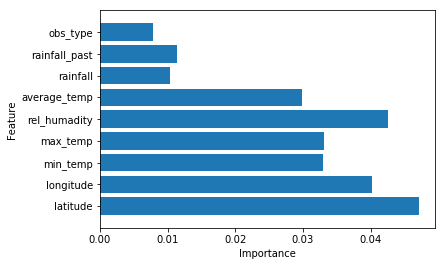

In [32]:
"""
Classification by Gradient Boosting
"""

from sklearn.ensemble import GradientBoostingClassifier

def gradient_boosting(train_x, train_y):
    gbrt = GradientBoostingClassifier(n_estimators=700, learning_rate=0.2,
                                      max_depth=9,
                                      random_state=9)
    gbrt.fit(train_x, train_y)
    return gbrt
    

def train2():
    dataset = pd.read_csv('dataset.csv', index_col=0)
    features = [ 
             'latitude', 'longitude', 
             'min_temp', 
             'max_temp', 
             'rel_humadity', 
             'average_temp', 
             'rainfall', 'rainfall_past',
             'obs_type',
    ]
    columns = features[:]
    columns.append('level')
    dataset = dataset[columns]
    display(dataset.tail())
    print(dataset.describe())
    train_x,test_x,train_y,test_y = split_dataset(dataset,0.7,features,"level")

    trained_model = gradient_boosting(train_x,train_y)
    prediction = trained_model.predict(test_x)

    display(pd.DataFrame({"actual": list(test_y), "predict": prediction}).T)

    print ("Train Accuracy :: ", accuracy_score(train_y,trained_model.predict(train_x)))
    print ("Test Accuracy :: ", accuracy_score(test_y,prediction))
    
    plot_feature_importances(features, trained_model)
    

train2()

In [53]:
"""
모기포집수 예측

2017년 8월 영등포구

obs_type: 1
latitude: 37.520829
longitude: 126.8783066
"""

def get_date_keys_monthly(year: int, month: int):
    """Getting Date Keys for Pandas Label
    
    Args:
        year (int): year
        month (int): month
    Return:
        list - date keys list
    """
    
    date_keys = []
    
    count_date = date(year, month, 1)
    end_date = date(year, month, get_days_of_month(year, month))
    
    while count_date <= end_date:
        date_keys.append(count_date.strftime("%Y-%m-%d"))
        count_date += timedelta(days=1)
    
    return date_keys


SEOUL_STN = 108
TARGET_YEAR = 2017
TARGET_MONTH = 8
CRAWL_OBS = ['average_temp', 'min_temp', 'max_temp', 'rel_humadity', 'rainfall']
FEATURE_ORDER = ['latitude', 'longitude', 
             'min_temp', 'min_temp_past',
             'max_temp', 'max_temp_past',
             'rel_humadity', 'rel_humadity_past',
             'average_temp', 'average_temp_past',
             'rainfall', 'rainfall_past',
             'obs_type',]

# Variable for count time
start_time = time.time()

# Crawl kma data from website
print("Crawling kma data...", end='\t')
kma_data = {'date': merge_lists([get_date_keys_monthly(TARGET_YEAR, TARGET_MONTH - 1), get_date_keys_monthly(TARGET_YEAR, TARGET_MONTH)])}
for obs in CRAWL_OBS:
    parsed_data = parse_kma_yearly(SEOUL_STN, TARGET_YEAR, obs)
    kma_data[obs] = merge_lists([parsed_data[6], parsed_data[7]])
for obs in CRAWL_OBS:
    past_data = kma_data[obs][:-1]
    past_data.insert(0, 0.0)
    kma_data[obs + "_past"] = past_data
dataset = pd.DataFrame(kma_data)
print("OK (%.2f sec)" % (time.time() - start_time))

# fill NaN, add obs info, and reorder columns
start_time = time.time()
print("Reformatting data...", end='\t')
dataset.rainfall = dataset.rainfall.apply(lambda x: 0.0 if math.isnan(x) else x)
dataset.rainfall_past = dataset.rainfall_past.apply(lambda x: 0.0 if math.isnan(x) else x)
dataset['obs_type'] = 1
dataset['latitude'] = 37.520829
dataset['longitude'] = 126.8783066
dataset = dataset[FEATURE_ORDER].tail(get_days_of_month(TARGET_YEAR, TARGET_MONTH))
dataset.index = range(len(dataset))
print("OK (%.2f sec)" % (time.time() - start_time))

# load trained model
with open("trained_model", "rb") as dumpfile:
    trained_model = pickle.load(dumpfile)

# Prediction
start_time = time.time()
print("Predicting...", end='\t')
predict_df = pd.DataFrame({'date': get_date_keys_monthly(TARGET_YEAR, TARGET_MONTH), 'level': trained_model.predict(dataset)})
print("OK (%.2f sec)" % (time.time() - start_time))
display(predict_df)

# Save result
predict_df.to_csv("predict_result.csv")

Crawling kma data...	OK (1.56 sec)
Reformatting data...	OK (0.00 sec)
Predicting...	OK (0.21 sec)


,date,level
0,2017-08-01,3
1,2017-08-02,1
2,2017-08-03,1
3,2017-08-04,3
4,2017-08-05,3
5,2017-08-06,1
6,2017-08-07,1
7,2017-08-08,3
8,2017-08-09,3
9,2017-08-10,4
